## Assignment 6

In [1]:
import os
import sys

methods_path = os.path.join(os.getcwd(), 'panel_data_methods')

In [2]:
sys.path.insert(0, methods_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(rc={'figure.figsize':(12, 8)})

np.random.seed(11148705)

In [4]:
from data import generate_data
from monte_carlo import monte_carlo_estimation, iterative_monte_carlo
from matrices import Diff_matrix, Q_matrix, projection, residual_matrix
from estimators import pooled, fixed_effects, first_diff

from gmm import standard_gmm, diagonal_gmm, lagged_gmm

### Parameters

In [5]:
sigmas = {
    'alpha': 1,
    'epsilon': 1,
    'xi': 1
}

init_coeff = {
    'rho': 0.5,
    'pi': 1,
    'theta': 0,
    'beta': 1
}

N = 100
T = 5

coeff = init_coeff.copy()

### Data generation

The data will be generated according the following functions

`stationary_x` produces the first row of $X, t=0$ according to the stationary rule:

\begin{equation}
    x_{i, 0} = \frac{\pi \alpha_i}{1 - \rho} + \frac{\theta \nu + \xi}{\sqrt{1 - \rho^2}}
\end{equation}

$X_0 \in \mathbb{R}^N$

Likewise `generate_data`, generates the full $y, X \in \mathbb{R}^{N\times T} $  

In [6]:
y, X = generate_data(T, N, sigmas, coeff)

print('Dimensions of X: ', X.shape)

Dimensions of X:  (100, 5)


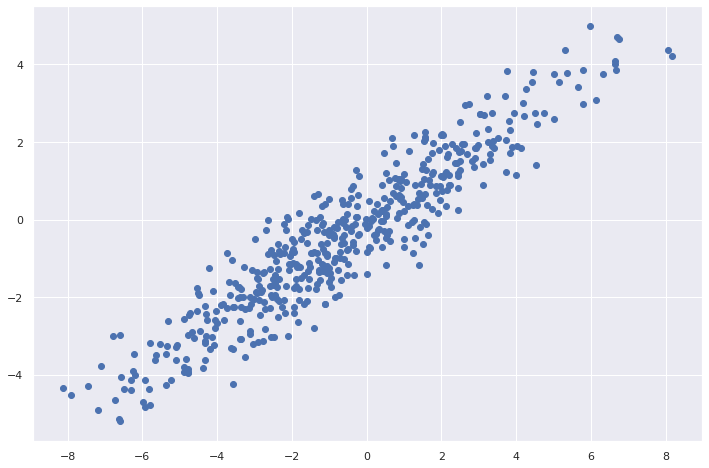

In [7]:
plt.scatter(y.reshape(-1, 1), X.reshape(-1, 1))
plt.show()

### Utils

These utils generate the $D$ (`Diff_matrix`), $Q$ (`Q_matrix`) and a `projection` and `residual_matrix` based on a generic matrix $X$

In [8]:
M_T = 4
M = np.arange(M_T)
print('First difference of ', M, '-->', M@Diff_matrix(M_T).T)
print('De-meaned of ', M, '--> ', M@Q_matrix(M_T))

First difference of  [0 1 2 3] --> [1. 1. 1.]
De-meaned of  [0 1 2 3] -->  [-1.5 -0.5  0.5  1.5]


## Q.1 - Standard estimators

Here we defined some simple estimators, in particular they all map $(X \times y) \xrightarrow{} \hat{\beta}_{lstsq}$:

- `pooled` implements a pooled OLS, i.e. a standard OLS to estimate $\theta = \begin{pmatrix}\hat{\alpha} \\ \hat{\beta}\end{pmatrix}$

- `fixed_effects` implements a de-meaned OLS as shown in Cameron & Trivedi (2005, p. 726) 

- `first_diff` implements an FD estimator

Note that under strict exogeneity ($\theta = 0$) `fixed_effects` and `pooled` will produce the same consistent estimator $\hat{\beta}$

In [9]:
X.shape

(100, 5)

In [10]:
beta_fixed = fixed_effects(y, X)

In [11]:
beta_diff = first_diff(y, X)

In [12]:
print(f"Estimated: \nfixed effects = {fixed_effects(y,X)[0]} \nfirst_diff= {first_diff(y, X)[0]}")

Estimated: 
fixed effects = 1.0173344943262008 
first_diff= 0.9848890531315069


### Monte carlo

In [13]:
models = {'first_diff': first_diff, 'fixed_effects': fixed_effects}
iterations = 1_000

r = monte_carlo_estimation(T, N, sigmas, coeff, models, iterations)

In [14]:
fd_beta = r['first_diff']['mean']
fe_beta = r['fixed_effects']['mean']

print('First difference MC-Beta: ',fd_beta, r['fixed_effects']['std'])
print('Fixed effect MC-beta', fe_beta, r['first_diff']['std'])

First difference MC-Beta:  0.9988429212443168 0.046842383594607226
Fixed effect MC-beta 0.9999552274921967 0.05463714611830946


### Summary results

In [15]:
iterations_space = np.logspace(2, 4, num=10).astype(int)
coeff = init_coeff.copy()
print(f'Number of iterations: {iterations_space}')

Number of iterations: [  100   166   278   464   774  1291  2154  3593  5994 10000]


In [16]:
betas, standard_dev = iterative_monte_carlo(iterations_space, 'iterations', T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

Below we can see estimation of the bias of different monte carlo simulation. Clearly both are consistent estimators as the $bias \xrightarrow{p} 0$

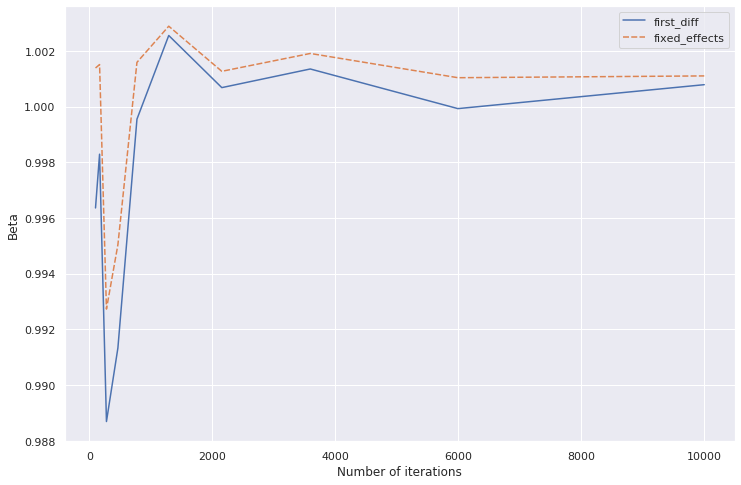

In [17]:
ax = sns.lineplot(data=betas)
ax.set(xlabel='Number of iterations', ylabel='Beta')
plt.show()

## Q.2 -  Robustness over $\pi$

Now we are going to explore the robustness of the estimators to changes in $\pi$. Clearly a change in $\pi$ should just change the effect of $\alpha_i$ on $x_{i, t}$ hence it should not hinder the consistency of the estimators

In [18]:
iterations = 1000
possible_pis = np.linspace(0.1, 30)
coeff = init_coeff.copy()

In [19]:
def plot_prob(betas, x = ''):
    sns.kdeplot(betas['fixed_effects'])
    sns.kdeplot(betas['first_diff'])
    plt.show()
    
    print('Value of Beta over ', x)
    ax = sns.lineplot(data=betas)
    ax.set(ylabel='Beta', xlabel=x)
    plt.show()

In [20]:
betas, standard_dev = iterative_monte_carlo(possible_pis, ['coeff', 'pi'] , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

It seems to be the case that our hypothesis is satisfied, i.e. perturbating $\pi$ does not affect the consistency of $\beta$ in fact the mean result is:


In [21]:
print('mean:\n', betas.mean())
print('\n')
print('standard deviation:\n', betas.std())

mean:
 first_diff       0.999047
fixed_effects    1.000129
dtype: float64


standard deviation:
 first_diff       0.000420
fixed_effects    0.000359
dtype: float64


## Q.3 -  Robustness over $\theta$

Now by increasing $\theta$, we increase the degree of endogeneity of $x_{i, t}$, hence we expect $\beta$ to be biased and inconsistent

In [22]:
iterations = 1000
possible_thetas = np.linspace(0, 5)
coeff = init_coeff.copy()

In [23]:
betas, standard_dev = iterative_monte_carlo(possible_thetas, ['coeff', 'theta'] , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

From the below plots it is clear that both estimators are inconsistent.

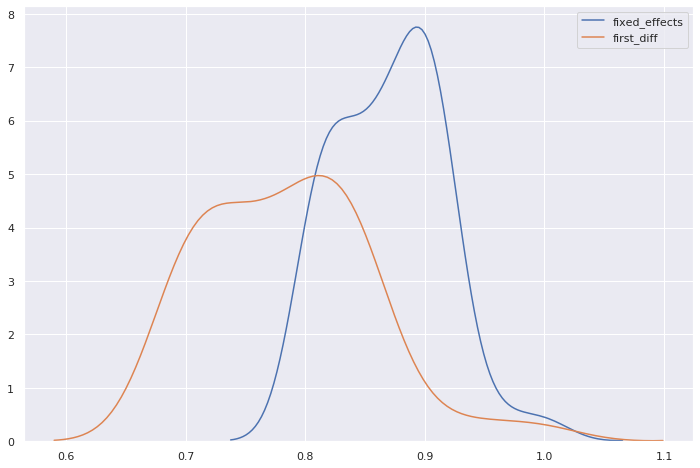

Value of Beta over  theta


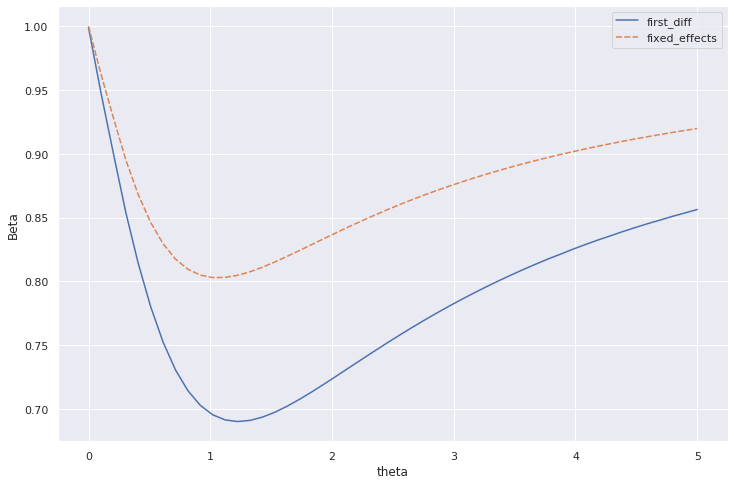

In [24]:
plot_prob(betas, x='theta')

We can now look at the consistency given an increase in $T$

In [25]:
coeff = init_coeff.copy()
betas, standard_dev = iterative_monte_carlo(possible_thetas, ['coeff', 'theta'] , T=30, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

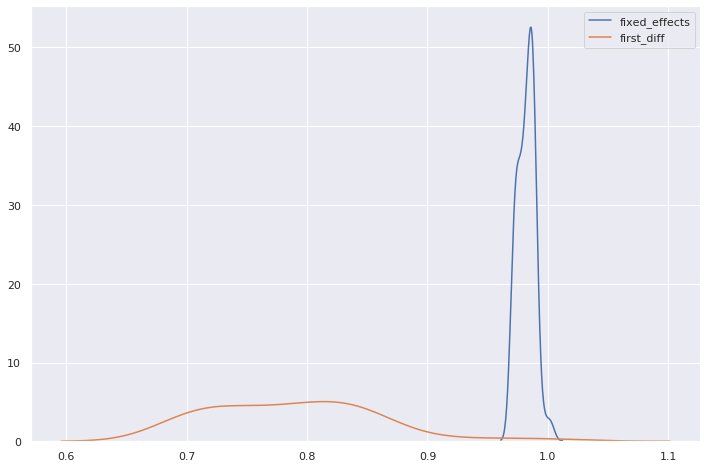

Value of Beta over  theta


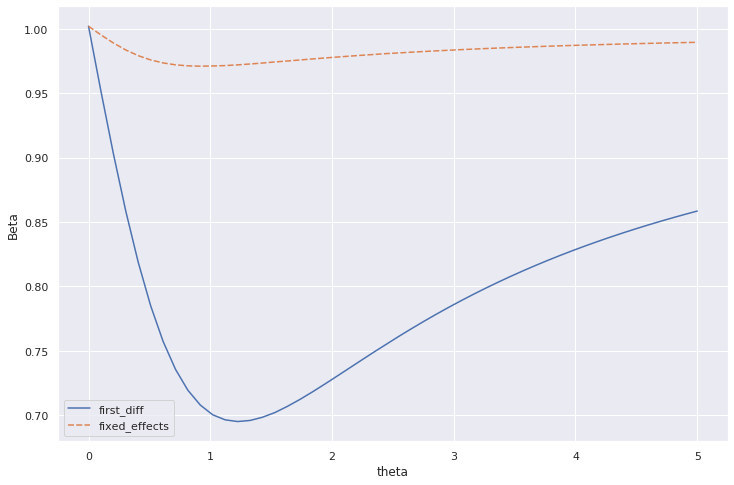

In [26]:
plot_prob(betas, x='theta')

## IV/GMM estimators

Now we are going to test the robustness of the GMM estimators to perturbations in $\theta$, in particular notice that 

\begin{equation} \label{eq1}
    \rho \neq 0 \land \theta \neq 0 \implies E\left[ \epsilon_{i, t} x_{i, s} \right] = 0 \ \forall s < t
\end{equation}

## Q.4 - $Z_i$ matrices

In [47]:
from gmm import make_instrument

In [55]:
y, X = generate_data(5, 100, sigmas, init_coeff)

print('The first instrument is: ', make_instrument(X, 'standard')[2])
print('And associated X: ', X[2])

The first instrument is:  [3.0014659  1.36902525 2.12576245 3.3039218 ]
And associated X:  [3.0014659  1.36902525 2.12576245 3.3039218  3.81370861]


In [57]:
print('The second instrument is: \n', make_instrument(X, 'diagonal')[2])
print('And associated X: ', X[2])

The second instrument is: 
 [[3.0014659  0.         0.         0.        ]
 [0.         1.36902525 0.         0.        ]
 [0.         0.         2.12576245 0.        ]
 [0.         0.         0.         3.3039218 ]]
And associated X:  [3.0014659  1.36902525 2.12576245 3.3039218  3.81370861]


In [59]:
print('The third instrument is: \n', make_instrument(X, 'lagged')[2])
print('\n')
print('And associated X: ', X[2])

The third instrument is: 
 [[3.0014659  0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         3.0014659  1.36902525 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         3.0014659  1.36902525 2.12576245
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  3.0014659  1.36902525 2.12576245 3.3039218 ]]


And associated X:  [3.0014659  1.36902525 2.12576245 3.3039218  3.81370861]


Above can see the three instrument matrices for observation $i=2$. 

- With the first instrument matrix, we are using all of the observations for individual $i$ as instruments, corresponding to the strong exogeneity assumption.
- In the second one, we are only using the previous observation as instrument, corresponding o the contemporenous exogeneity assumption.
- In the third one we are using the full relevant history for each time period, corresponding to the weak exogeneity.

## Q.5 

As we can see blow, the GMM estimation is much more robust than standard OLS esitmators. Despite perturbing $\theta$, the estimator remains consistent due to the fewer assumption on the dgp.

(1) Exploiting a suboptimal matrix (e.g. `lagged_gmm` over the `standard_gmm`) would increase computation time (due to inverting a bigger matrix) and increase the variance of the estimator.

(2) By using more instruments, an increase in persistence in the data ($\rho$) would lead to weaker instruments. Furthermore the size of the `lagged_gmm` increases substaintially in size.

In [71]:
models = {
    'standard': standard_gmm,
    'diagonal': diagonal_gmm,
    'lagged': lagged_gmm
}

In [29]:
possible_thetas = np.linspace(0, 0.7)
coeff = init_coeff.copy()

In [30]:
betas, standard_dev = iterative_monte_carlo(possible_thetas, ['coeff', 'theta'] , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

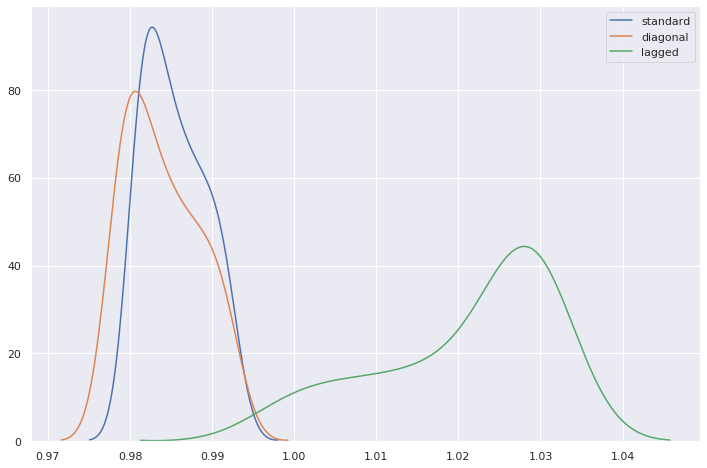

Value of Beta over theta


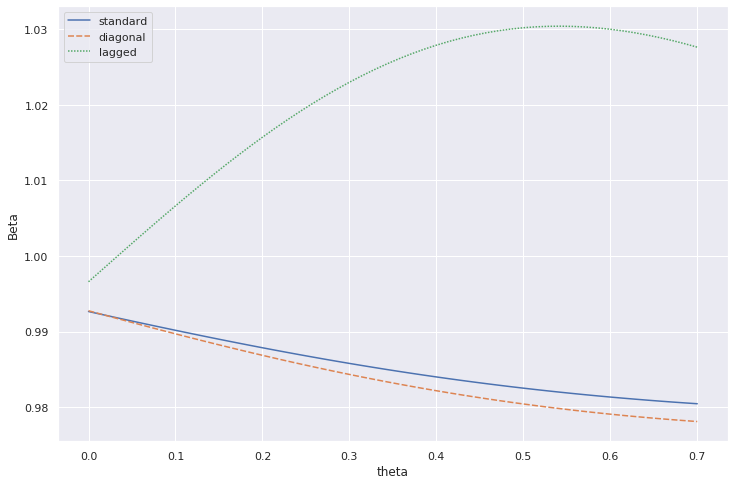

In [31]:
sns.kdeplot(betas['standard'])
sns.kdeplot(betas['diagonal'])
sns.kdeplot(betas['lagged'])
plt.show()

print('Value of Beta over theta')
ax = sns.lineplot(data=betas)
ax.set(ylabel='Beta', xlabel='theta')
plt.show()

In [32]:
coeff = init_coeff.copy()

### Contemporeneous exogeneity $\rho = 0$

In [33]:
coeff = init_coeff.copy()
coeff['rho'] = 0

In [34]:
betas, standard_dev = iterative_monte_carlo(possible_thetas, ['coeff', 'theta'] , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

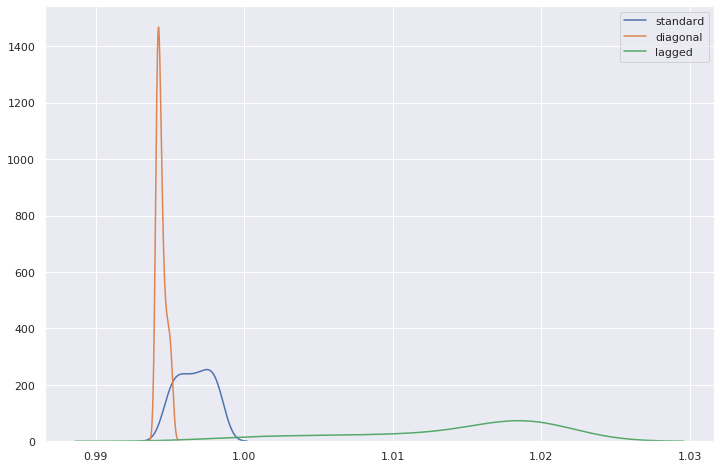

Value of Beta over theta


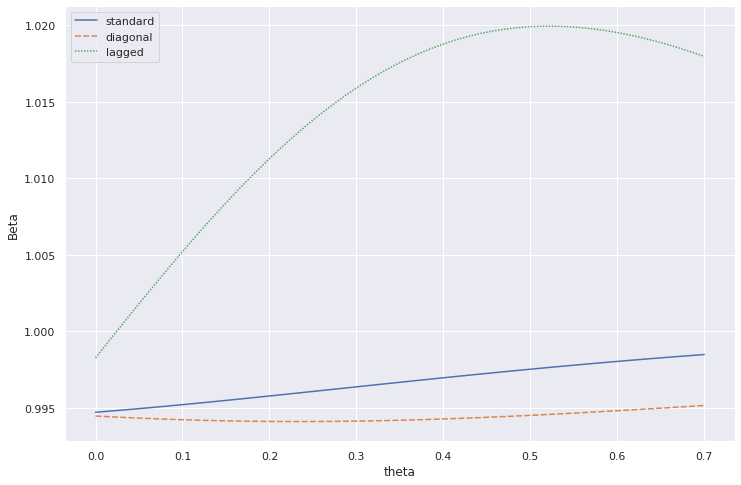

In [35]:
sns.kdeplot(betas['standard'])
sns.kdeplot(betas['diagonal'])
sns.kdeplot(betas['lagged'])
plt.show()

print('Value of Beta over theta')
ax = sns.lineplot(data=betas)
ax.set(ylabel='Beta', xlabel='theta')
plt.show()

## Q. 6 

We can try and increase the sample size and see the effect on the gmm estimators.

In [73]:
size = [10, 50, 100, 300, 500]
betas, standard_dev = iterative_monte_carlo(size, 'N', T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

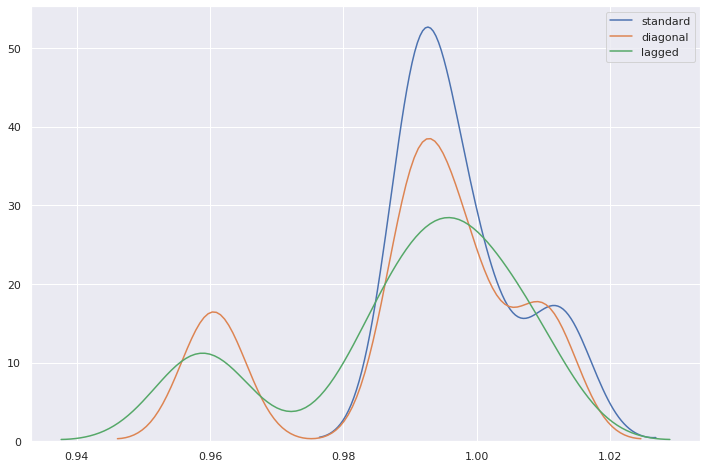

Value of Beta over theta


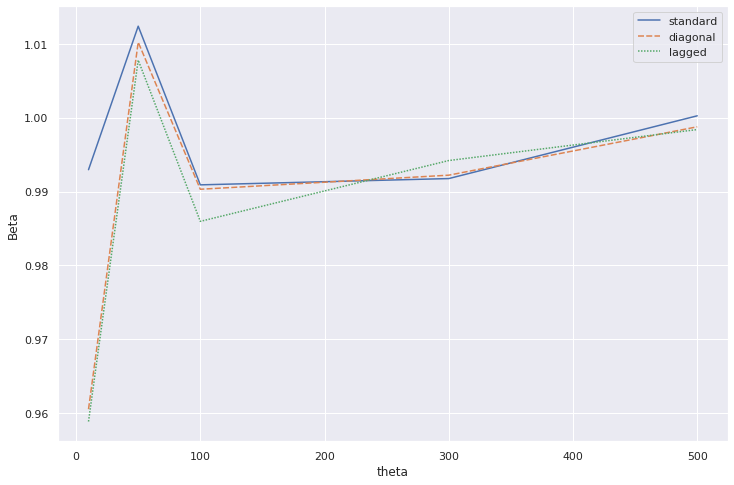

In [74]:
sns.kdeplot(betas['standard'])
sns.kdeplot(betas['diagonal'])
sns.kdeplot(betas['lagged'])
plt.show()

print('Value of Beta over theta')
ax = sns.lineplot(data=betas)
ax.set(ylabel='Beta', xlabel='theta')
plt.show()

## Q.7 - As $\rho \xrightarrow{} 1$...

As $\rho \xrightarrow{} 1$, the model approaches

\begin{equation}
    x_{t, i} \approx x_{t-1, i} + \pi \cdot \alpha_i + \epsilon_{t, i}
\end{equation}

then the GMM estimation of $\beta$ and $\rho$ should not yield any result because taking a first difference of 

\begin{equation}
    \Delta x_{t} \approx \pi \cdot \alpha_i + \epsilon_{t, i}
\end{equation}

would not allow to extract any information since $\Delta x_{t}$ reduces to a random walk.

Below you can see how this effect makes it impossible to estimate $\beta$ or $\rho$.

In [36]:
coeff = init_coeff.copy()
coeff['rho'] = 0.99

In [37]:
betas, standard_dev = iterative_monte_carlo(possible_thetas, ['coeff', 'theta'] , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff)

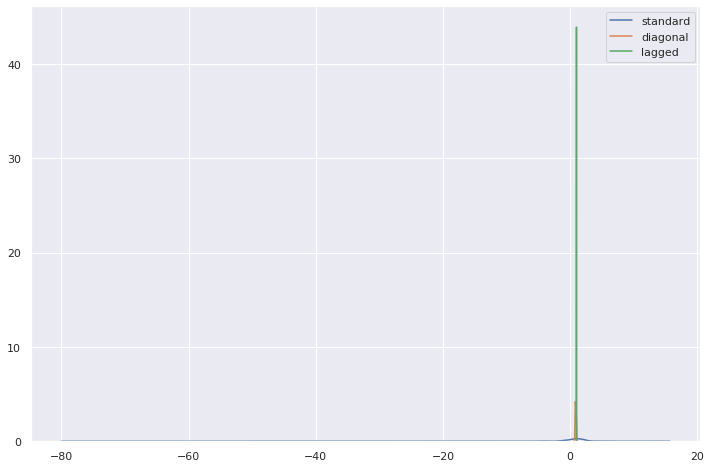

Value of Beta over theta


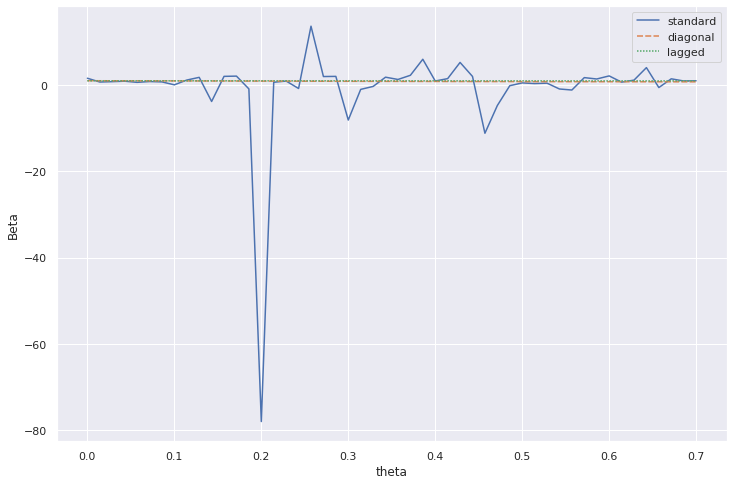

In [38]:
sns.kdeplot(betas['standard'])
sns.kdeplot(betas['diagonal'])
sns.kdeplot(betas['lagged'])
plt.show()

print('Value of Beta over theta')
ax = sns.lineplot(data=betas)
ax.set(ylabel='Beta', xlabel='theta')
plt.show()

In [39]:
def generate_X(*args_data_gen, **kwargs_data_gen):
    _, X = generate_data(*args_data_gen, **kwargs_data_gen)
    y = X[:, 1:]
    X = X[:, :-1]
    
    
    return y, X

In [40]:
coeff = init_coeff.copy()
coeff['rho'] = .99

In [41]:
betas, standard_dev = iterative_monte_carlo(possible_thetas, ['coeff', 'theta'] , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff, generate_data=generate_X)

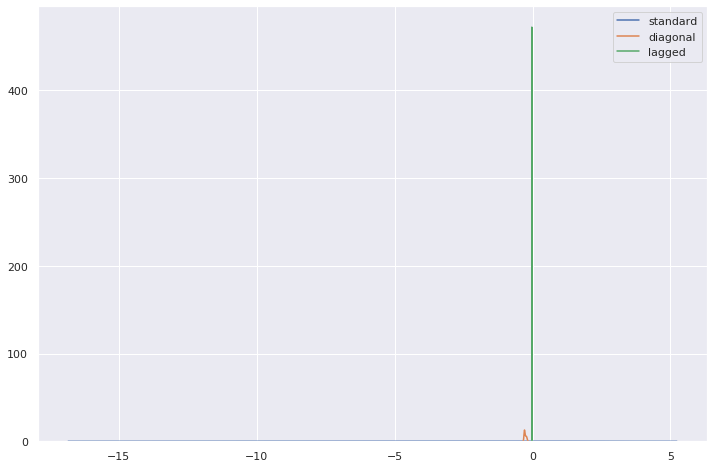

Value of Beta over theta


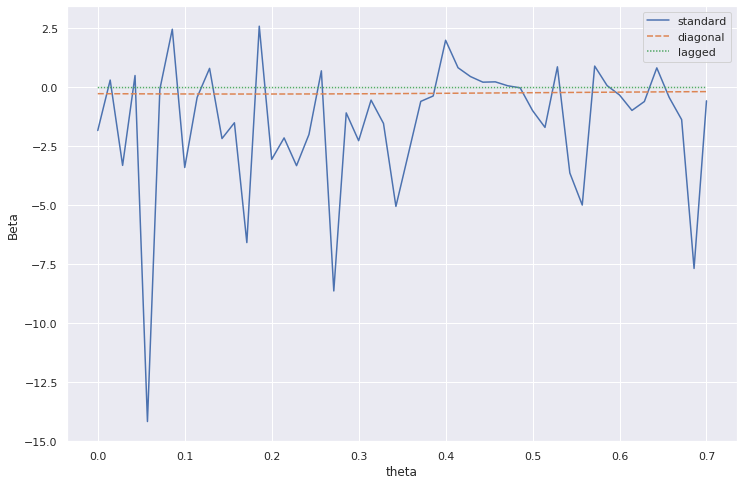

In [42]:
sns.kdeplot(betas['standard'])
sns.kdeplot(betas['diagonal'])
sns.kdeplot(betas['lagged'])
plt.show()

print('Value of Beta over theta')
ax = sns.lineplot(data=betas)
ax.set(ylabel='Beta', xlabel='theta')
plt.show()

As $N$ increases!

In [75]:
coeff = init_coeff.copy()
coeff['rho'] = .5

models = {'first_diff': first_diff, 'fixed_effects': fixed_effects}

In [76]:
betas, standard_dev = iterative_monte_carlo(size, 'N' , T=T, N=N, sigmas=sigmas, estimators=models, coeff=coeff, generate_data=generate_X)

In [81]:
betas.mean()

first_diff      -0.480197
fixed_effects   -0.213899
dtype: float64

As seen before due to correlation between $x_{t, i}$ and $\epsilon_{t-1, i}$ it is not possible to estimate consistently $\rho$. This will be shown more formally in the next question